<a href="https://colab.research.google.com/github/Mauville/MedCLIP/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [46]:
%pip install timm 

%pip install transformers
%pip install albumentations 

%pip install opencv-python 

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [5]:
from IPython import display as ipythondisplay
from torch import nn

from tqdm.autonotebook import tqdm
from transformers import AutoTokenizer, AutoModel
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer
import albumentations as A
import cv2
import gc
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import time
import timm
import torch
import torch.nn.functional as F
from clipDataset import  CLIPDataset
from cfg import CFG
print(CFG.batch_size)
print(CFG.device)

C:\Users\BHOGI SAI SATHWIK\AppData\Local\Temp\ipykernel_22396\954265298.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


12
cuda


In [3]:
import torch

# Check if CUDA is available
cuda_available = torch.cuda.is_available()

if cuda_available:
    print(f"CUDA is available. Number of GPUs: {torch.cuda.device_count()}")
    print(f"Current device: {torch.cuda.current_device()}")
    print(f"Device name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("CUDA is not available.")


CUDA is available. Number of GPUs: 1
Current device: 0
Device name: NVIDIA GeForce RTX 3050 Laptop GPU


## Some pre-preocessing

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# df = pd.read_csv(r"C:\Users\BHOGI SAI SATHWIK\Desktop\DL_DATASET_PROJECT\ROCOv2\all_in_one_captions.csv") 
# # df.rename(columns={"filename":"image", "grouped_diag":"caption"},inplace=True)
# df.rename(columns={"ID":"image", "Caption":"caption"},inplace=True)
# # Append ".jpg" to each entry in the "image" column for all dataframes


# # Display the updated DataFrame
# df.head()
# Modify the file paths accordingly
training_df=pd.read_csv(r"C:\Users\BHOGI SAI SATHWIK\Desktop\DL_DATASET_PROJECT\ROCOv2\train_captions.csv")
validation_df=pd.read_csv(r"C:\Users\BHOGI SAI SATHWIK\Desktop\DL_DATASET_PROJECT\ROCOv2\valid_captions.csv")
testing_df=pd.read_csv(r"C:\Users\BHOGI SAI SATHWIK\Desktop\DL_DATASET_PROJECT\ROCOv2\/test_captions.csv")

training_df.rename(columns={"ID":"image", "Caption":"caption"},inplace=True)
validation_df.rename(columns={"ID":"image", "Caption":"caption"},inplace=True)
testing_df.rename(columns={"ID":"image", "Caption":"caption"},inplace=True)
# df["image"] = df["image"] + ".jpg"
training_df["image"] = training_df["image"] + ".jpg"
validation_df["image"] = validation_df["image"] + ".jpg"
testing_df["image"] = testing_df["image"] + ".jpg"

# # Retain only the first 1/3rd of each dataframe
# train_len = len(training_df) // 3
# valid_len = len(validation_df) // 3
# test_len = len(testing_df) // 3

# # Slice the dataframes to retain only the first 1/3rd
# training_df = training_df[:train_len]
# validation_df = validation_df[:valid_len]
# testing_df = testing_df[:test_len]

# Concatenate the first 1/3rd of each dataframe
df = pd.concat([training_df, validation_df, testing_df], ignore_index=True)




df.head()

image  \
0  ROCOv2_2023_train_000001.jpg   
1  ROCOv2_2023_train_000002.jpg   
2  ROCOv2_2023_train_000003.jpg   
3  ROCOv2_2023_train_000004.jpg   
4  ROCOv2_2023_train_000005.jpg   

                                             caption  
0            Head CT demonstrating left parotiditis.  
1  Acquired renal cysts in end-stage renal failur...  
2  Computed tomography of the chest showing the r...  
3  Lateral view of the sacrum showing the low con...  
4  Thoracic CT scan showing perihilar pulmonary l...

In [ ]:


image_path = "/home/kewang_zhili/DL_PROJECT_DATASET/ROCOv2"
captions_path = "/home/kewang_zhili/DL_PROJECT_DATASET/ROCOv2"






## Config
Global config for all the project. present in cgf.py file

## Utils

THIS CONTAINS CODE FOR SOME UTILITY FUNCTIONS

In [8]:
class AvgMeter:
    def __init__(self, name="Metric"):
        self.name = name
        self.reset()

    def reset(self):
        self.avg, self.sum, self.count = [0] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += val * count
        self.avg = self.sum / self.count

    def __repr__(self):
        text = f"{self.name}: {self.avg:.4f}"
        return text

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]


## Dataset

THIS CONTAINS THE CODE TO LOAD THE DATA TO THE MODEL. THE SAME IS PRESENT IN THE FILE clipdataset.py

In [ ]:
# Custom dataset object. Will tokenize text and apply transforms to images before yielding them.

class CLIPDataset(torch.utils.data.Dataset):
    def __init__(self, image_filenames, captions, tokenizer, transforms):
        """
        image_filenames and cpations must have the same length; so, if there are
        multiple captions for each image, the image_filenames must have repetitive
        file names 
        """

        self.image_filenames = image_filenames
        self.captions = list(captions)
        self.skippedImgCount = 0
        self.encoded_captions = tokenizer(
            list(captions), padding=True, truncation=True, max_length=CFG.max_length
        )
        self.transforms = transforms

    def __getitem__(self, idx):
        item = {
            key: torch.tensor(values[idx])
            for key, values in self.encoded_captions.items()
        }
       
        image = cv2.imread(f"{CFG.image_path}/{self.image_filenames[idx]}")
        if image is None:
          self.skippedImgCount += 1
          return self.__getitem__(1)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transforms(image=image)['image']
        item['image'] = torch.tensor(image).permute(2, 0, 1).float()
        item['caption'] = self.captions[idx]

        return item


    def __len__(self):
        return len(self.captions)



def get_transforms(mode="train"):
    if mode == "train":
        return A.Compose(
            [
                A.Resize(CFG.size, CFG.size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )
    else:
        return A.Compose(
            [
                A.Resize(CFG.size, CFG.size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )



## Image Encoder

In [10]:
class ImageEncoder(nn.Module):
    """
    Encode images to a fixed size vector
    """

    def __init__(
        self, model_name=CFG.model_name, pretrained=CFG.pretrained, trainable=CFG.trainable
    ):
        super().__init__()
        self.model = timm.create_model(
            model_name, pretrained, num_classes=0, global_pool="avg"
        )
        for p in self.model.parameters():
            p.requires_grad = trainable

    def forward(self, x):
        return self.model(x)

## Text Encoder

In [11]:
class TextEncoder(nn.Module):
    def __init__(self, model_name=CFG.text_encoder_model, pretrained=CFG.pretrained, trainable=CFG.trainable):
        super().__init__()
        if pretrained:
            # self.model = DistilBertModel.from_pretrained(model_name)

            # Use Bio-ClinicalBERT
            self.model = AutoModel.from_pretrained(CFG.clinical_encoder_model)

        else:
            self.model = DistilBertModel(config=DistilBertConfig())
            
        for p in self.model.parameters():
            p.requires_grad = trainable

        # we are using the CLS token hidden representation as the sentence's embedding
        self.target_token_idx = 0

    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = output.last_hidden_state
        return last_hidden_state[:, self.target_token_idx, :]

## Projection Head

In [12]:
# Get both image and text encodings into a same size matrix
class ProjectionHead(nn.Module):
    def __init__(
        self,
        embedding_dim,
        projection_dim=CFG.projection_dim,
        dropout=CFG.dropout
    ):
        super().__init__()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)
    
    def forward(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected
        x = self.layer_norm(x)
        return x

## CLIP

#### Check the cell below this code block for the continue of the explanations

In [13]:
class CLIPModel(nn.Module):
    def __init__(
        self,
        temperature=CFG.temperature,
        image_embedding=CFG.image_embedding,
        text_embedding=CFG.text_embedding,
    ):
        super().__init__()
        self.image_encoder = ImageEncoder()
        self.text_encoder = TextEncoder()
        self.image_projection = ProjectionHead(embedding_dim=image_embedding)
        self.text_projection = ProjectionHead(embedding_dim=text_embedding)
        self.temperature = temperature

    def forward(self, batch):
        # Getting Image and Text Features
        image_features = self.image_encoder(batch["image"])
        text_features = self.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        # Getting Image and Text Embeddings (with same dimension)
        image_embeddings = self.image_projection(image_features)
        text_embeddings = self.text_projection(text_features)

        # Calculating the Loss
        logits = (text_embeddings @ image_embeddings.T) / self.temperature
        images_similarity = image_embeddings @ image_embeddings.T
        texts_similarity = text_embeddings @ text_embeddings.T
        targets = F.softmax(
            (images_similarity + texts_similarity) / 2 * self.temperature, dim=-1
        )
        texts_loss = cross_entropy(logits, targets, reduction='none')
        images_loss = cross_entropy(logits.T, targets.T, reduction='none')
        loss =  (images_loss + texts_loss) / 2.0 # shape: (batch_size)
        return loss.mean()


def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()

The perfect relationship between encoded images and captions is described by their encoded representations being the same.
This similarity can easily be measured by looking at the softmax between the dot product of the encoded inputs; a perfect encoding will yield the identity matrix.
The loss on each iteration is calculated using cross entropy on the dot product between the encodings.

In [14]:
# A simple Example


batch_size = 4
dim = 256
embeddings = torch.randn(batch_size, dim)
out = embeddings @ embeddings.T
print(F.softmax(out, dim=-1))

tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])


## Train

In [15]:
from clipDataset import  CLIPDataset
from cfg import CFG
def build_loaders(dataframe, tokenizer, mode):
    transforms = get_transforms(mode=mode)
    dataset = CLIPDataset(
        dataframe["image"].values,
        dataframe["caption"].values,
        tokenizer=tokenizer,
        transforms=transforms,
    )
    
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=CFG.batch_size,
        num_workers=CFG.num_workers,
        shuffle=True if mode == "train" else False,
    )
    return dataloader

In [16]:

class PeriodicPlotter:
  def __init__(self, sec, xlabel='', ylabel='', scale=None):

    self.xlabel = xlabel
    self.ylabel = ylabel
    self.sec = sec
    self.scale = scale

    self.tic = time.time()

  def plot(self, data):
    if time.time() - self.tic > self.sec:
      plt.cla()

      if self.scale is None:
        plt.plot(data)
      elif self.scale == 'semilogx':
        plt.semilogx(data)
      elif self.scale == 'semilogy':
        plt.semilogy(data)
      elif self.scale == 'loglog':
        plt.loglog(data)
      else:
        raise ValueError("unrecognized parameter scale {}".format(self.scale))

      plt.xlabel(self.xlabel); plt.ylabel(self.ylabel)
      ipythondisplay.clear_output(wait=True)
      
      ipythondisplay.display(plt.gcf())

      self.tic = time.time()

In [17]:
from clipDataset import CLIPDataset

def train_epoch(model, train_loader, optimizer, lr_scheduler, step):
    plotter = PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
    loss_meter = AvgMeter()
    tqdm_object = tqdm(train_loader, total=len(train_loader))
    history = []
    for batch in tqdm_object:
        batch = {k: v.to(CFG.device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step == "batch":
            lr_scheduler.step()

        count = batch["image"].size(0)
        

        loss_meter.update(loss.item(), count)

        history.append(loss.cpu().detach().numpy().mean())
        
        tqdm_object.set_postfix(train_loss=loss_meter.avg, lr=get_lr(optimizer))
    plotter.plot(history)
    return loss_meter


def valid_epoch(model, valid_loader):
    loss_meter = AvgMeter()

    tqdm_object = tqdm(valid_loader, total=len(valid_loader))
    for batch in tqdm_object:
        batch = {k: v.to(CFG.device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(valid_loss=loss_meter.avg)
    return loss_meter





def main():
    train_df = training_df
    valid_df = validation_df
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    tokenizer = AutoTokenizer.from_pretrained(CFG.clinical_encoder_model)
    train_loader = build_loaders(train_df, tokenizer, mode="train")
    valid_loader = build_loaders(valid_df, tokenizer, mode="valid")


    model = CLIPModel().to(CFG.device)
    params = [
        {"params": model.image_encoder.parameters(), "lr": CFG.image_encoder_lr},
        {"params": model.text_encoder.parameters(), "lr": CFG.text_encoder_lr},
        {"params": itertools.chain(
            model.image_projection.parameters(), model.text_projection.parameters()
        ), "lr": CFG.head_lr, "weight_decay": CFG.weight_decay}
    ]
    optimizer = torch.optim.AdamW(params, weight_decay=0.)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=CFG.patience, factor=CFG.factor
    )
    step = "epoch"

    best_loss = float('inf')

    history = []
    for epoch in range(CFG.epochs): 
        print(f"Epoch: {epoch + 1}")
        model.train()
        train_loss = train_epoch(model, train_loader, optimizer, lr_scheduler, step)
        model.eval()
        torch.save(model.state_dict(), "temp.pt")
        with torch.no_grad():
            valid_loss = valid_epoch(model, valid_loader)
        
        if valid_loss.avg < best_loss:
            best_loss = valid_loss.avg
            torch.save(model.state_dict(), "best.pt")
            print("Saved Best Model!")
        
        lr_scheduler.step(valid_loss.avg)
    print(f"CAREFUL! I had to skip {train_loader.dataset.skippedImgCount} to finish. This introduces heavy bias to whatever dataset[0] was at the time of training")    


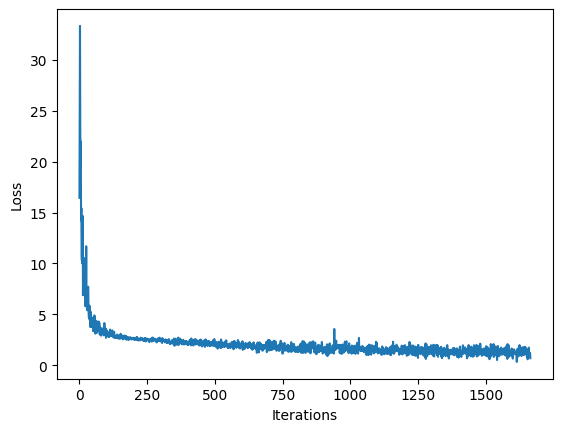

  0%|          | 0/276 [00:00<?, ?it/s]

RecursionError: Caught RecursionError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "c:\python\python311\Lib\site-packages\torch\utils\data\_utils\worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
           ^^^^^^^^^^^^^^^^^^^^
  File "c:\python\python311\Lib\site-packages\torch\utils\data\_utils\fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\python\python311\Lib\site-packages\torch\utils\data\_utils\fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
            ~~~~~~~~~~~~^^^^^
  File "c:\Users\BHOGI SAI SATHWIK\Desktop\DL_DATASET_PROJECT\clipDataset.py", line 43, in __getitem__
    return self.__getitem__(1)
           ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\BHOGI SAI SATHWIK\Desktop\DL_DATASET_PROJECT\clipDataset.py", line 43, in __getitem__
    return self.__getitem__(1)
           ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\BHOGI SAI SATHWIK\Desktop\DL_DATASET_PROJECT\clipDataset.py", line 43, in __getitem__
    return self.__getitem__(1)
           ^^^^^^^^^^^^^^^^^^^
  [Previous line repeated 2985 more times]
  File "c:\Users\BHOGI SAI SATHWIK\Desktop\DL_DATASET_PROJECT\clipDataset.py", line 36, in __getitem__
    item = {
           ^
  File "c:\Users\BHOGI SAI SATHWIK\Desktop\DL_DATASET_PROJECT\clipDataset.py", line 37, in <dictcomp>
    key: torch.tensor(values[idx])
         ^^^^^^^^^^^^^^^^^^^^^^^^^
RecursionError: maximum recursion depth exceeded while calling a Python object


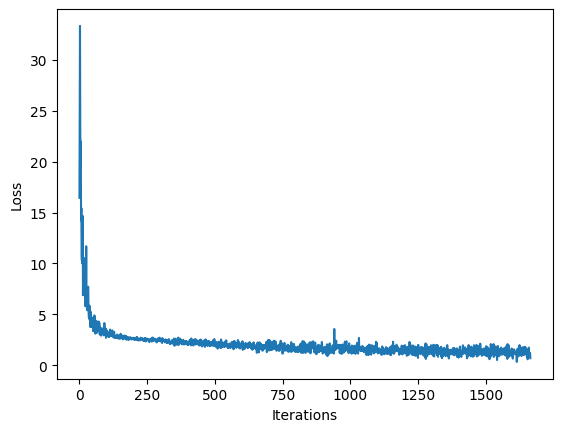

In [17]:
# Run to start training
main()
# /Users/himangshudeka/Desktop/DL_DATASET_PROJECT/ROCOv2/train/ROCOv2_2023_train_000014.jpg

Auto copy weights file to Drive so I can sleep in  peace.

---



In [ ]:
# !cp -r './best.pt' /content/drive/Shareddrives/DeepLearning/datav2/withDiagnostics2.pt
#TODO:: Provide own local path

## Inference

### Getting Image Embeddings

In this function, we are loading the model that we saved after training, feeding it images in validation set and returning the image_embeddings with shape (valid_set_size, 256) and the model itself.

In [18]:
def get_image_embeddings(valid_df, model_path):
    # tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    tokenizer = AutoTokenizer.from_pretrained(CFG.clinical_encoder_model)
    print(tokenizer)
    valid_loader = build_loaders(valid_df, tokenizer, mode="valid")
    
    model = CLIPModel().to(CFG.device)
    model.load_state_dict(torch.load(model_path, map_location=CFG.device))
    model.eval()
    
    valid_image_embeddings = []
    with torch.no_grad():
        for batch in tqdm(valid_loader):
            print(batch["image"])
            image_features = model.image_encoder(batch["image"].to(CFG.device))
            image_embeddings = model.image_projection(image_features)
            valid_image_embeddings.append(image_embeddings)
    return model, torch.cat(valid_image_embeddings)

def get_text_embeddings(valid_df, model_path):
    # tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    tokenizer = AutoTokenizer.from_pretrained(CFG.clinical_encoder_model)
    valid_loader = build_loaders(valid_df, tokenizer, mode="valid")
    
    model = CLIPModel().to(CFG.device)
    model.load_state_dict(torch.load(model_path, map_location=CFG.device))
    model.eval()
    
    valid_text_embeddings = []
    with torch.no_grad():
        for batch in tqdm(valid_loader):
            text_features = model.text_encoder(
                input_ids=batch["input_ids"].to(CFG.device), attention_mask=batch["attention_mask"].to(CFG.device)
            )
            text_embeddings = model.text_projection(text_features)
            valid_text_embeddings.append(text_embeddings)
    return model, torch.cat(valid_text_embeddings)
    

In [19]:
# Aliased to avoid bad sampling
valid_df = validation_df
valid_df.head()

image  \
0  ROCOv2_2023_valid_000001.jpg   
1  ROCOv2_2023_valid_000002.jpg   
2  ROCOv2_2023_valid_000003.jpg   
3  ROCOv2_2023_valid_000004.jpg   
4  ROCOv2_2023_valid_000005.jpg   

                                             caption  
0  Chest X-ray showing enlarged cardiac silhouett...  
1  Digital subtraction ureterogram with contrast ...  
2  Fifty-eight-year-old woman with 2 cancers: one...  
3                     CT scan image for lung cancer.  
4                     A giant retroperitoneal tumor.

In [31]:


model, image_embeddings = get_image_embeddings(valid_df, CFG.saved_model_clinical)

BertTokenizerFast(name_or_path='emilyalsentzer/Bio_ClinicalBERT', vocab_size=28996, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}


  0%|          | 0/826 [00:00<?, ?it/s]

tensor([[[[ 0.2796, -0.7822, -1.3644,  ...,  0.9817,  1.0331,  1.2043],
          [-1.1589, -1.8268, -1.9467,  ...,  0.6563,  0.7762,  0.9303],
          [-1.4672, -1.9295, -1.9124,  ..., -1.3815, -1.1760, -0.6965],
          ...,
          [-1.8610, -1.8953, -1.8953,  ..., -1.9124, -1.5357, -0.4911],
          [-1.7754, -1.8097, -1.8097,  ..., -1.9295, -1.5185, -0.4568],
          [-1.5699, -1.6042, -1.6042,  ..., -1.9124, -1.4500, -0.4054]],

         [[ 0.4153, -0.6702, -1.2654,  ...,  1.1331,  1.1856,  1.3606],
          [-1.0553, -1.7381, -1.8606,  ...,  0.8004,  0.9230,  1.0805],
          [-1.3704, -1.8431, -1.8256,  ..., -1.2829, -1.0728, -0.5826],
          ...,
          [-1.7731, -1.8081, -1.8081,  ..., -1.8256, -1.4405, -0.3725],
          [-1.6856, -1.7206, -1.7206,  ..., -1.8431, -1.4230, -0.3375],
          [-1.4755, -1.5105, -1.5105,  ..., -1.8256, -1.3529, -0.2850]],

         [[ 0.6356, -0.4450, -1.0376,  ...,  1.3502,  1.4025,  1.5768],
          [-0.8284, -1.5081, -

In [21]:
model, text_embeddings = get_text_embeddings(valid_df, CFG.saved_model_clinical)

  0%|          | 0/826 [00:00<?, ?it/s]

c:\python\python311\Lib\site-packages\transformers\models\bert\modeling_bert.py:440: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


### Finding Matches

This function does the final task that we wished our model would be capable of: it gets the model, image_embeddings, and a text query. It will display the most relevant images from the validation set! Isn't it amazing? Let's see how it performs after all!

In [22]:
def find_matches(model, image_embeddings, query, image_filenames, n=9):
    # tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    tokenizer = AutoTokenizer.from_pretrained(CFG.clinical_encoder_model)
    encoded_query = tokenizer([query])
    batch = {
        key: torch.tensor(values).to(CFG.device)
        for key, values in encoded_query.items()
    }
    with torch.no_grad():
        text_features = model.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        text_embeddings = model.text_projection(text_features)
    
    image_embeddings_n = F.normalize(image_embeddings, p=2, dim=-1)
    text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)
    dot_similarity = text_embeddings_n @ image_embeddings_n.T
    
    values, indices = torch.topk(dot_similarity.squeeze(0), n * 5)
    matches = [image_filenames[idx] for idx in indices[::5]]
    
    _, axes = plt.subplots(3, 3, figsize=(10, 10))
    
    metrics = get_metrics(matches, query)
    save_metrics('distil_metrics_results.csv', metrics)
    print(matches)
    for match, ax in zip(matches, axes.flatten()):
        image = cv2.imread(f"{CFG.image_path}/{match}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(image)
        ax.axis("off")
    
    plt.show()

In [23]:
def find_matches_from_image(model, text_embeddings, image_query, captions, n=9):
    CFG.image_path=r"C:\Users\BHOGI SAI SATHWIK\Desktop\DL_DATASET_PROJECT\ROCOv2"
    image = cv2.imread(f"{CFG.image_path}/{image_query}")
    if image is None:
      print("GDRIVE DIDN'T READ AGAIN!")
      return 'NO_IMG_IN_GDRIVE'

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = get_transforms("valid")(image=image)['image']

    # Dymb loader
    tokenizer = AutoTokenizer.from_pretrained(CFG.clinical_encoder_model)
    dummy_df = pd.DataFrame.from_dict({"image": [image_query], "caption":[""]})
    dumb_loader = build_loaders(dummy_df, tokenizer, mode="valid")

    valid_image_embeddings = []
    with torch.no_grad():
        for batch in tqdm(dumb_loader):
            image_features = model.image_encoder(batch["image"].to(CFG.device))
            image_embeddings = model.image_projection(image_features)
            valid_image_embeddings.append(image_embeddings)

    image_embeddings_n = F.normalize(image_embeddings[0], p=2, dim=-1)
    print(image_embeddings_n.size)

    text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)
    print(text_embeddings_n.size)
    dot_similarity = image_embeddings_n @ text_embeddings_n.T
    
    values, indices = torch.topk(dot_similarity.squeeze(0), n )
    matches = [captions[idx] for idx in indices[::5]]
    
    return matches

In [24]:
# find_matches(model, image_embeddings, query="a frontal XR scan of spine trauma", image_filenames=valid_df['image'].values, n=9)

## Metrics


In [53]:
!pip install nltk
!pip install rouge
!pip install pycocoevalcap


In [54]:
!pip install -U nltk
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to C:\Users\BHOGI SAI
[nltk_data]     SATHWIK\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# https://arxiv.org/pdf/1504.00325.pdf
# To ensure consistency in evaluation of automatic caption generation algorithms, an
# evaluation server is used. The evaluation server receives candidate captions and scores them using several popular metrics, including
# BLEU, METEOR, ROUGE and CIDEr.

from pycocoevalcap.tokenizer.ptbtokenizer import PTBTokenizer
from pycocoevalcap.bleu.bleu import Bleu as BleuCoco
from pycocoevalcap.meteor.meteor import Meteor as MeteorCoco
from pycocoevalcap.rouge.rouge import Rouge as RougeCoco
from pycocoevalcap.cider.cider import Cider

import matplotlib.pyplot as plt
import pandas as pd

class COCOEvalCap:
    def __init__(self,images,gts,res):
        self.evalImgs = []
        self.eval = {}
        self.imgToEval = {}
        self.params = {'image_id': images}
        self.gts = gts
        self.res = res

    def evaluate(self):
        imgIds = self.params['image_id']
        gts = self.gts
        res = self.res

        # =================================================
        # Set up scorers
        # =================================================
        tokenizer = PTBTokenizer()
        gts  = tokenizer.tokenize(gts)
        res = tokenizer.tokenize(res)

        # =================================================
        # Set up scorers
        # =================================================
        scorers = [
            (BleuCoco(), "Bleu_1"),
            (MeteorCoco(),"METEOR"),
            (RougeCoco(), "ROUGE_L"),
            (Cider(), "CIDEr")
        ]

        # =================================================
        # Compute scores
        # =================================================
        eval = {}
        for scorer, method in scorers:
            print('computing %s score...'%(scorer.method()))
            score, scores = scorer.compute_score(gts, res)
            if type(method) == list:
                for sc, scs, m in zip(score, scores, method):
                    self.setEval(sc, m)
                    self.setImgToEvalImgs(scs, imgIds, m)
                    print("%s: %0.3f"%(m, sc))
            else:
                self.setEval(score, method)
                self.setImgToEvalImgs(scores, imgIds, method)
                print("%s: %0.3f"%(method, score))
        self.setEvalImgs()

    def setEval(self, score, method):
        self.eval[method] = score

    def setImgToEvalImgs(self, scores, imgIds, method):
        for imgId, score in zip(imgIds, scores):
            if not imgId in self.imgToEval:
                self.imgToEval[imgId] = {}
                self.imgToEval[imgId]["image_id"] = imgId
            self.imgToEval[imgId][method] = score

    def setEvalImgs(self):
        self.evalImgs = [eval for imgId, eval in self.imgToEval.items()]

class EvaluationServer:
  def __init__(self):
    self.last_idx = 0
    self.groundtruths = dict()
    self.hypothesis = dict()

  def add(self, caption, matches):
    print(f'Adding caption: {self.last_idx}  to evaluator')
    start_idx = self.last_idx
    for i, match in enumerate(matches):
      idx = start_idx + i
      self.groundtruths[idx] = [{'image_id': idx, 'caption': caption}]
      self.hypothesis[idx] = [{'image_id': idx, 'caption': match}]
      self.last_idx += 1

  def present_metrics(self):
    print(f'Calculating scores for all {self.last_idx} captions:\n')
    rng = range(self.last_idx)
    evalObj = COCOEvalCap(rng,self.groundtruths,self.hypothesis)
    evalObj.evaluate()
    scores = evalObj.eval

    df = pd.DataFrame(scores, columns=scores.keys(), index=['one'])

    fig, ax = plt.subplots() 

    # Hide axes
    fig.patch.set_visible(False)
    ax.axis('off')
    ax.axis('tight')

    print('Model scores using Microsofts Coco Evaluation Server:')
    table = ax.table(cellText=df.values, colLabels=df.columns, loc='center')



In [35]:
from rouge import Rouge
from nltk.tokenize import TreebankWordTokenizer
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import meteor_score
from pycocoevalcap.tokenizer.ptbtokenizer import PTBTokenizer
from pycocoevalcap.cider.cider import Cider
import matplotlib.pyplot as plt
import pandas as pd
import cv2

plt.rcParams['figure.figsize'] = [20, 7]

# This tokenizer performs the following steps:
#   split standard contractions, e.g. don't -> do n't and they'll -> they 'll
#   treat most punctuation characters as separate tokens
#   split off commas and single quotes, when followed by whitespace
#   separate periods that appear at the end of line
def tokenize(s):
  return TreebankWordTokenizer().tokenize(s)

# Cumulative scores of bluee, n gram scores.
# Match ngrams from candidate to n-grams in reference text. 
# Regardless of word order.
def get_bleu(query, groundtruth):
    reference = [tokenize(groundtruth)]
    candidate = tokenize(query)
    bleu_1 = sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))
    # bleu_2 = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
    # bleu_3 = sentence_bleu(reference, candidate, weights=(0.33, 0.33, 0.33))
    # bleu_4 = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25))
    return {"bleu_1": bleu_1}

# Rouge has different variants, the recomemnded one is rouge-l, 
# which stands calculates precisio,  recall and F1-measure based
# on the length of the longest common subsequence.
# The desired metrics result is the F1-measure.
def get_rouge(query, groundtruth, variant="rouge-l", measure="f"):
    rouge = Rouge()
    rouge_scores = rouge.get_scores(query, groundtruth)
    return rouge_scores[0][variant][measure]

# Meteor evaluates the caption by first calculating bleu_1
# between generated and ground truth to find matching results.
# Computes harmonic mean.
def get_meteor(query, groundtruth):
    hypothesis = [tokenize(query)]
    reference = tokenize(groundtruth)
    return meteor_score(hypothesis, reference)

# Somethings wrong:: https://gist.github.com/kracwarlock/c979b10433fe4ac9fb97
# got 0.0
def get_cider(query, groundtruth):
    tokenizer = PTBTokenizer()
    gts  = tokenizer.tokenize({0: [{"image_id": 0, "caption": groundtruth}]})
    res = tokenizer.tokenize({0: [{"image_id": 0, "caption": query}]})
    cider = Cider()
    return cider.compute_score(gts,res)

def get_scores(query, groundtruth):
    scores = dict()
    for k, v in get_bleu(query, groundtruth).items():
        scores[k] = v
    scores["rouge-l"]  = get_rouge(query, groundtruth)
    scores["meteor"] = get_meteor(query, groundtruth)
    # vale, arr = get_cider(query, groundtruth)
    return scores

def present_scores(imagename, caption, matches):
    headers = []
    scores = []

    print('Recomended captions:\n')

    for match in matches:

      score = get_scores(match, caption)
      scores.append(score)
      headers = score.keys()

      print(f'\t- {match}')

    print('Scores for every recommended caption:\n')

    # Set scores dataframe
    df = pd.DataFrame(scores, columns=headers, index=matches)
    df.update(df.applymap('{:.4f}'.format))

    # Create table
    fig, ax = plt.subplots(2,1)

    # Hide axes
    fig.patch.set_visible(False)
    ax[1].axis('off')
    ax[1].axis('tight')
    # ax[2].axis('off')
    # ax[2].axis('tight')

    # mdf = pd.DataFrame(df.index, columns=["Matches"])

    # Create table
    # table = ax[1].table(cellText=mdf.values, colLabels=mdf.columns, loc='center')
    table = ax[1].table(cellText=df.values, colLabels=df.columns, loc='center')

    # Create image
    image = cv2.imread(f"{CFG.image_path}/{imagename}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax[0].imshow(image)
    ax[0].axis('off')
    plt.show()



In [ ]:
def get_n_random_image_match(n):
  imagesdf = testing_df.sample(n=n)
  # print(imagesdf)
  for index, row in imagesdf.iterrows():
    print(f"Image inserted: {row['image']}\nReal caption: {row['caption']}\n")

    # Top 3 matches from model.
    matches = find_matches_from_image(model, 
                            text_embeddings,
                            image_query=row.image,
                            captions=testing_df['caption'].values,
                            n=3)
    present_scores(row.image, row.caption, matches)

def evaluate_model(nsamples=40):
  imagesdf = testing_df.sample(n=nsamples)
  eval = EvaluationServer()
  # print(imagesdf)
  for index, row in imagesdf.iterrows():

    # Top 3 matches from model.
    matches = find_matches_from_image(model, 
                            text_embeddings,
                            image_query=row.image,
                            captions=testing_df['caption'].values,
                            n=3)
    if matches != 'NO_IMG_IN_GDRIVE':
      eval.add(row['caption'], matches)

  eval.present_metrics()
    

Image inserted: ROCOv2_2023_train_055749.jpg
Real caption: Parasternal Long Axis ViewLA, Left atrium; AO, Aorta; LV, Left ventricle.



  0%|          | 0/1 [00:00<?, ?it/s]

<built-in method size of Tensor object at 0x000001A7077973B0>
<built-in method size of Tensor object at 0x000001A7077961B0>
Recomended captions:

	- Contrast Enhanced Computerized Tomography (CECT) of abdomen and pelvis (axial section) showing right angiomyolipoma.
Scores for every recommended caption:



c:\python\python311\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\python\python311\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\python\python311\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C

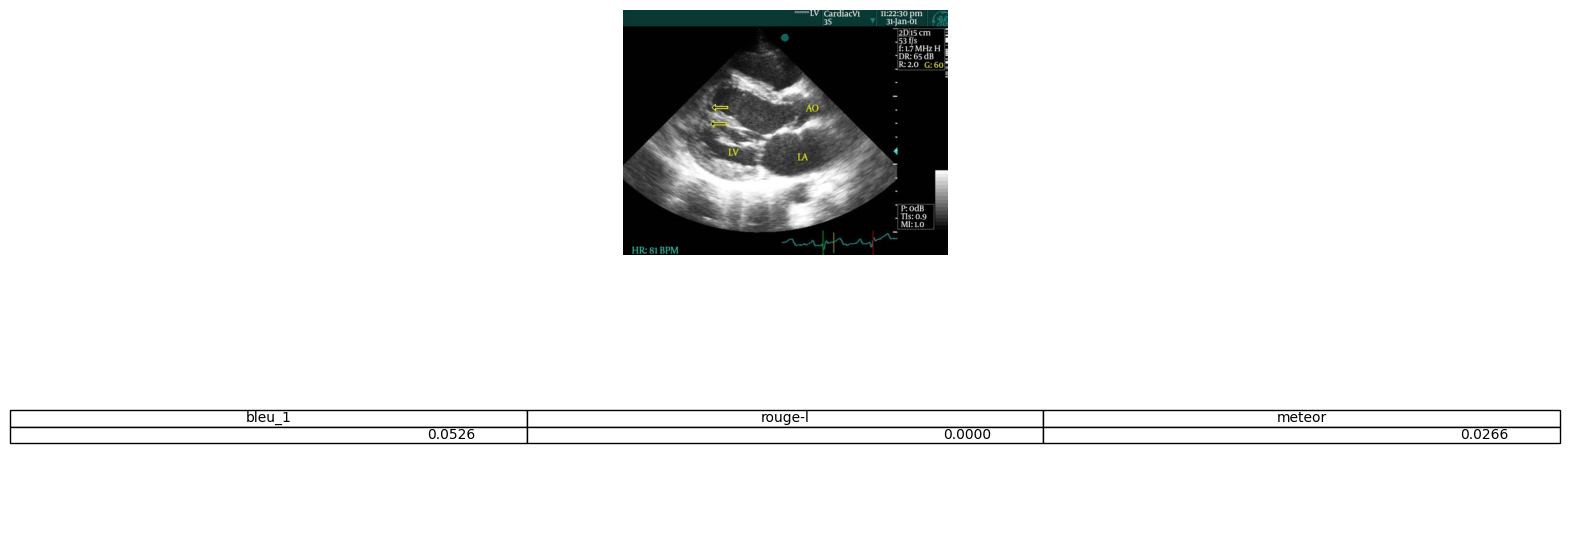

Image inserted: ROCOv2_2023_train_003990.jpg
Real caption: Migrated dental implant into the left maxillary sinus.



  0%|          | 0/1 [00:00<?, ?it/s]

<built-in method size of Tensor object at 0x000001A707782270>
<built-in method size of Tensor object at 0x000001A707783A70>
Recomended captions:

	- Post-treatment lateral radiograph demonstrating increased sclerosis of the site of the lesion. The treatment tract can be seen from anterior to posterior going toward the lesion.
Scores for every recommended caption:



c:\python\python311\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\python\python311\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\python\python311\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C

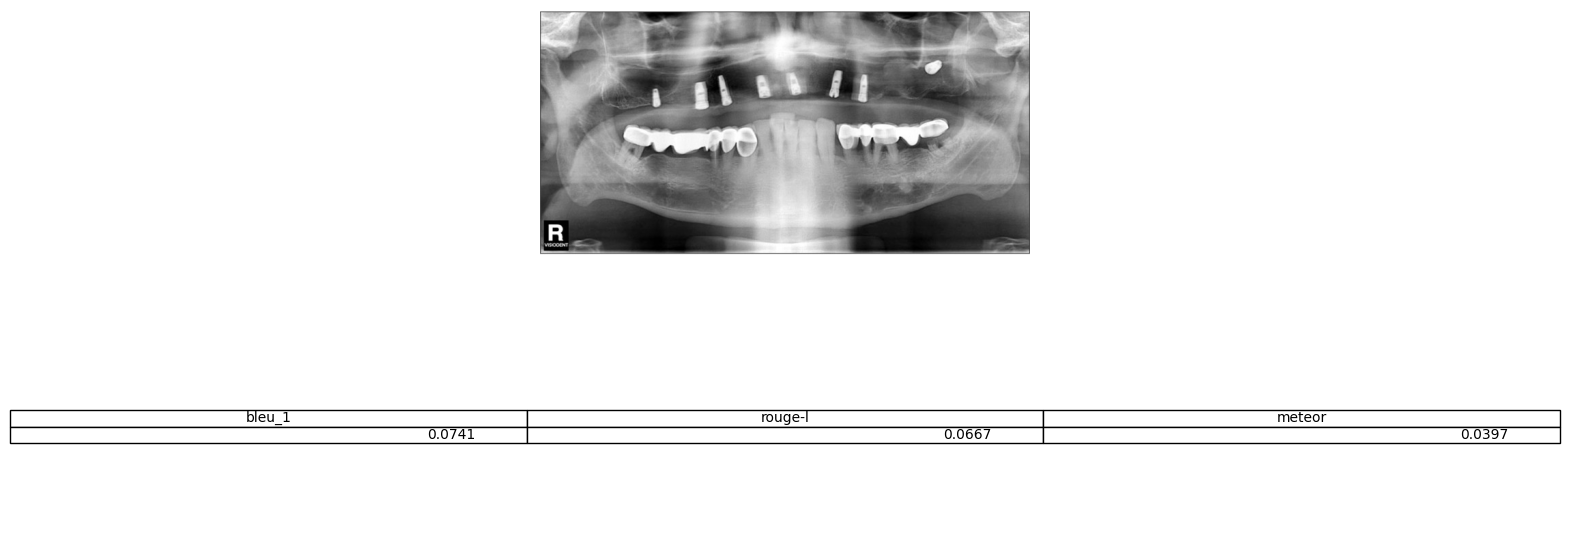

Image inserted: ROCOv2_2023_train_018004.jpg
Real caption: The position of the locking cannulated blade plate (LCBP) over the guidewire is almost central, in the femoral neck, in the lateral projection. There can be no angulation between the LCBP and the guidewire.



  0%|          | 0/1 [00:00<?, ?it/s]

<built-in method size of Tensor object at 0x000001A7077C98B0>
<built-in method size of Tensor object at 0x000001A7077CA4B0>
Recomended captions:

	- Coronary angiogram showing a large aneurysm at the level of the anastomosis between the right coronary artery and the saphenous vein graft, with extravasation of the contrast agent.
Scores for every recommended caption:



c:\python\python311\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\python\python311\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\BHOGI SAI SATHWIK\AppData\Local\Temp\ipykernel_22396\1169566974.py:86: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df.update(df.applymap('{:.4f}'.format))
C:\Users\BHOGI SAI SATHWIK\AppData\Local\Temp\ipykernel_22396\1169566974.py:86: FutureWarning: Setting an item of incompatible dty

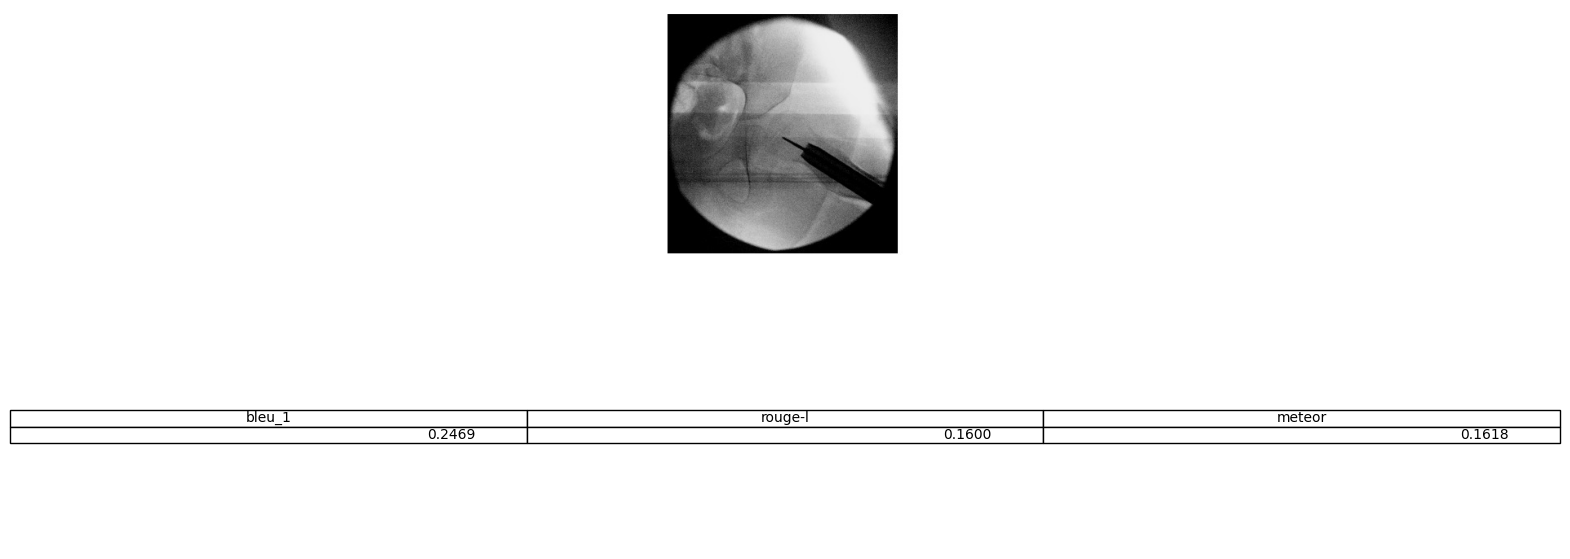

Image inserted: ROCOv2_2023_train_022951.jpg
Real caption: Right-sided sacroiliitis persisting 1 month after diagnosis.



  0%|          | 0/1 [00:00<?, ?it/s]

<built-in method size of Tensor object at 0x000001A7086D3590>
<built-in method size of Tensor object at 0x000001A7086D2810>
Recomended captions:

	- T2 magnetic resonance imaging brain showing grossly unremarkable intracranial findings.
Scores for every recommended caption:



c:\python\python311\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\python\python311\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\python\python311\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C

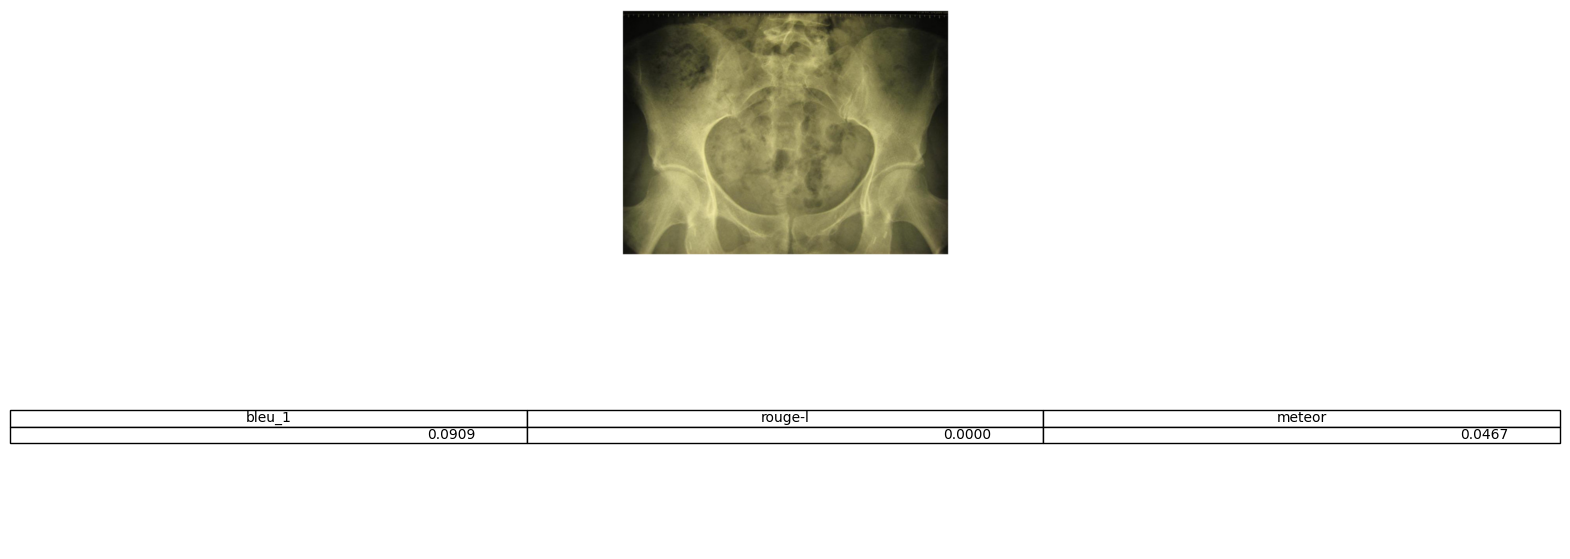

Image inserted: ROCOv2_2023_train_025239.jpg
Real caption: T2-MRI showing fluid in the ear and sinuses



  0%|          | 0/1 [00:00<?, ?it/s]

<built-in method size of Tensor object at 0x000001A7086D33B0>
<built-in method size of Tensor object at 0x000001A7086D3650>
Recomended captions:

	- Patient with left ventricular hypertrophy with no determined cause. Echocardiogram showing shiny or granular scintillating aspect of the myocardium suggestive of cardiac amyloidosis. PE: pericardial effusion; LA: left atrium; LV: left ventricle; RV: right ventricle; RA: right atrium.
Scores for every recommended caption:



c:\python\python311\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\python\python311\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\python\python311\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C

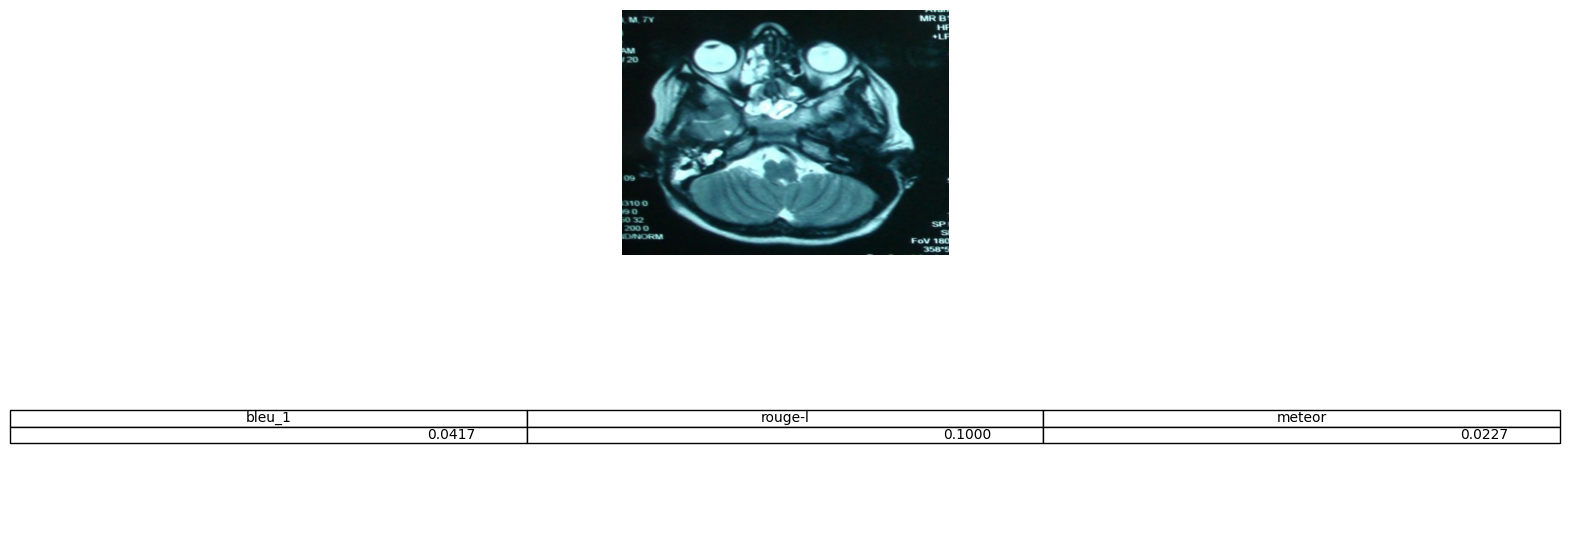

In [42]:

get_n_random_image_match(5)

In [40]:
image_embeddings

tensor([[-0.1124, -3.1430,  0.2658,  ...,  0.3008, -0.0376, -0.3337],
        [-0.1236, -2.9806,  0.4089,  ...,  0.4064, -0.1466, -0.0897],
        [-0.1464, -3.0006,  0.4287,  ...,  0.4293, -0.1202, -0.0820],
        ...,
        [-0.0635, -3.0884,  0.2246,  ...,  0.3563, -0.0810, -0.3171],
        [ 0.0333, -3.0934,  0.4276,  ...,  0.4689, -0.1171, -0.0082],
        [-0.0130, -3.1687,  0.2056,  ...,  0.1794, -0.0726, -0.2913]],
       device='cuda:0')

  0%|          | 0/1 [00:00<?, ?it/s]

<built-in method size of Tensor object at 0x000001A70377AC30>
<built-in method size of Tensor object at 0x000001A703696690>
Adding caption: 0  to evaluator


  0%|          | 0/1 [00:00<?, ?it/s]

<built-in method size of Tensor object at 0x000001A7061506B0>
<built-in method size of Tensor object at 0x000001A67DB8BE90>
Adding caption: 1  to evaluator


  0%|          | 0/1 [00:00<?, ?it/s]

<built-in method size of Tensor object at 0x000001A67DB8BE30>
<built-in method size of Tensor object at 0x000001A67DB8BA70>
Adding caption: 2  to evaluator


  0%|          | 0/1 [00:00<?, ?it/s]

<built-in method size of Tensor object at 0x000001A706150C50>
<built-in method size of Tensor object at 0x000001A7061512B0>
Adding caption: 3  to evaluator


  0%|          | 0/1 [00:00<?, ?it/s]

<built-in method size of Tensor object at 0x000001A6FBA7CEF0>
<built-in method size of Tensor object at 0x000001A7061512B0>
Adding caption: 4  to evaluator


  0%|          | 0/1 [00:00<?, ?it/s]

<built-in method size of Tensor object at 0x000001A706151BB0>
<built-in method size of Tensor object at 0x000001A706150E90>
Adding caption: 5  to evaluator


  0%|          | 0/1 [00:00<?, ?it/s]

<built-in method size of Tensor object at 0x000001A7061520F0>
<built-in method size of Tensor object at 0x000001A7061519D0>
Adding caption: 6  to evaluator


  0%|          | 0/1 [00:00<?, ?it/s]

<built-in method size of Tensor object at 0x000001A706152090>
<built-in method size of Tensor object at 0x000001A706152330>
Adding caption: 7  to evaluator


  0%|          | 0/1 [00:00<?, ?it/s]

<built-in method size of Tensor object at 0x000001A706152630>
<built-in method size of Tensor object at 0x000001A7061528D0>
Adding caption: 8  to evaluator


  0%|          | 0/1 [00:00<?, ?it/s]

<built-in method size of Tensor object at 0x000001A706150A70>
<built-in method size of Tensor object at 0x000001A706152A50>
Adding caption: 9  to evaluator


  0%|          | 0/1 [00:00<?, ?it/s]

<built-in method size of Tensor object at 0x000001A706152CF0>
<built-in method size of Tensor object at 0x000001A706152FF0>
Adding caption: 10  to evaluator


  0%|          | 0/1 [00:00<?, ?it/s]

<built-in method size of Tensor object at 0x000001A706152F30>
<built-in method size of Tensor object at 0x000001A7061535F0>
Adding caption: 11  to evaluator


  0%|          | 0/1 [00:00<?, ?it/s]

<built-in method size of Tensor object at 0x000001A706153290>
<built-in method size of Tensor object at 0x000001A7061528D0>
Adding caption: 12  to evaluator


  0%|          | 0/1 [00:00<?, ?it/s]

<built-in method size of Tensor object at 0x000001A706153EF0>
<built-in method size of Tensor object at 0x000001A706152F30>
Adding caption: 13  to evaluator


  0%|          | 0/1 [00:00<?, ?it/s]

<built-in method size of Tensor object at 0x000001A7060C54F0>
<built-in method size of Tensor object at 0x000001A706153650>
Adding caption: 14  to evaluator


  0%|          | 0/1 [00:00<?, ?it/s]

<built-in method size of Tensor object at 0x000001A7060C53D0>
<built-in method size of Tensor object at 0x000001A7060C50D0>
Adding caption: 15  to evaluator


  0%|          | 0/1 [00:00<?, ?it/s]

<built-in method size of Tensor object at 0x000001A7060C5010>
<built-in method size of Tensor object at 0x000001A7060C53D0>
Adding caption: 16  to evaluator


  0%|          | 0/1 [00:00<?, ?it/s]

<built-in method size of Tensor object at 0x000001A7060C4B30>
<built-in method size of Tensor object at 0x000001A7060C4050>
Adding caption: 17  to evaluator


  0%|          | 0/1 [00:00<?, ?it/s]

<built-in method size of Tensor object at 0x000001A67DCDF0B0>
<built-in method size of Tensor object at 0x000001A7060C5610>
Adding caption: 18  to evaluator


  0%|          | 0/1 [00:00<?, ?it/s]

<built-in method size of Tensor object at 0x000001A7060C4650>
<built-in method size of Tensor object at 0x000001A7060C42F0>
Adding caption: 19  to evaluator


  0%|          | 0/1 [00:00<?, ?it/s]

<built-in method size of Tensor object at 0x000001A7060C4650>
<built-in method size of Tensor object at 0x000001A7060C4D10>
Adding caption: 20  to evaluator


  0%|          | 0/1 [00:00<?, ?it/s]

<built-in method size of Tensor object at 0x000001A7060C6210>
<built-in method size of Tensor object at 0x000001A7060C42F0>
Adding caption: 21  to evaluator


  0%|          | 0/1 [00:00<?, ?it/s]

<built-in method size of Tensor object at 0x000001A7060C6210>
<built-in method size of Tensor object at 0x000001A7060C5A30>
Adding caption: 22  to evaluator


  0%|          | 0/1 [00:00<?, ?it/s]

<built-in method size of Tensor object at 0x000001A7060C6210>
<built-in method size of Tensor object at 0x000001A7060C6570>
Adding caption: 23  to evaluator


  0%|          | 0/1 [00:00<?, ?it/s]

<built-in method size of Tensor object at 0x000001A7060C5CD0>
<built-in method size of Tensor object at 0x000001A7060C6870>
Adding caption: 24  to evaluator


  0%|          | 0/1 [00:00<?, ?it/s]

<built-in method size of Tensor object at 0x000001A7060C6D50>
<built-in method size of Tensor object at 0x000001A7037794F0>
Adding caption: 25  to evaluator


  0%|          | 0/1 [00:00<?, ?it/s]

<built-in method size of Tensor object at 0x000001A7060C6330>
<built-in method size of Tensor object at 0x000001A7060C7110>
Adding caption: 26  to evaluator


  0%|          | 0/1 [00:00<?, ?it/s]

<built-in method size of Tensor object at 0x000001A7060C7770>
<built-in method size of Tensor object at 0x000001A7060C76B0>
Adding caption: 27  to evaluator


  0%|          | 0/1 [00:00<?, ?it/s]

<built-in method size of Tensor object at 0x000001A7060C7B30>
<built-in method size of Tensor object at 0x000001A7060C73B0>
Adding caption: 28  to evaluator


  0%|          | 0/1 [00:00<?, ?it/s]

<built-in method size of Tensor object at 0x000001A7060C6630>
<built-in method size of Tensor object at 0x000001A706091370>
Adding caption: 29  to evaluator


  0%|          | 0/1 [00:00<?, ?it/s]

<built-in method size of Tensor object at 0x000001A706091490>
<built-in method size of Tensor object at 0x000001A706091250>
Adding caption: 30  to evaluator


  0%|          | 0/1 [00:00<?, ?it/s]

<built-in method size of Tensor object at 0x000001A7060914F0>
<built-in method size of Tensor object at 0x000001A7060910D0>
Adding caption: 31  to evaluator


  0%|          | 0/1 [00:00<?, ?it/s]

<built-in method size of Tensor object at 0x000001A67DB8BCB0>
<built-in method size of Tensor object at 0x000001A706091130>
Adding caption: 32  to evaluator


  0%|          | 0/1 [00:00<?, ?it/s]

<built-in method size of Tensor object at 0x000001A7036B3590>
<built-in method size of Tensor object at 0x000001A706090B90>
Adding caption: 33  to evaluator


  0%|          | 0/1 [00:00<?, ?it/s]

<built-in method size of Tensor object at 0x000001A7060902F0>
<built-in method size of Tensor object at 0x000001A7060900B0>
Adding caption: 34  to evaluator


  0%|          | 0/1 [00:00<?, ?it/s]

<built-in method size of Tensor object at 0x000001A67DCDF0B0>
<built-in method size of Tensor object at 0x000001A706091A30>
Adding caption: 35  to evaluator


  0%|          | 0/1 [00:00<?, ?it/s]

<built-in method size of Tensor object at 0x000001A706091970>
<built-in method size of Tensor object at 0x000001A7060910D0>
Adding caption: 36  to evaluator


  0%|          | 0/1 [00:00<?, ?it/s]

<built-in method size of Tensor object at 0x000001A706152C90>
<built-in method size of Tensor object at 0x000001A7060900B0>
Adding caption: 37  to evaluator


  0%|          | 0/1 [00:00<?, ?it/s]

<built-in method size of Tensor object at 0x000001A706092990>
<built-in method size of Tensor object at 0x000001A7060926F0>
Adding caption: 38  to evaluator


  0%|          | 0/1 [00:00<?, ?it/s]

<built-in method size of Tensor object at 0x000001A7060920F0>
<built-in method size of Tensor object at 0x000001A706092DB0>
Adding caption: 39  to evaluator
Calculating scores for all 40 captions:

computing Bleu score...
{'testlen': 712, 'reflen': 1053, 'guess': [712, 672, 632, 592], 'correct': [98, 12, 0, 0]}
ratio: 0.6761633428293674
Bleu_1: 0.085
Bleu_2: 0.031
Bleu_3: 0.000
Bleu_4: 0.000
computing METEOR score...
METEOR: 0.029
computing Rouge score...
ROUGE_L: 0.086
computing CIDEr score...
CIDEr: 0.031
Model scores using Microsofts Coco Evaluation Server:


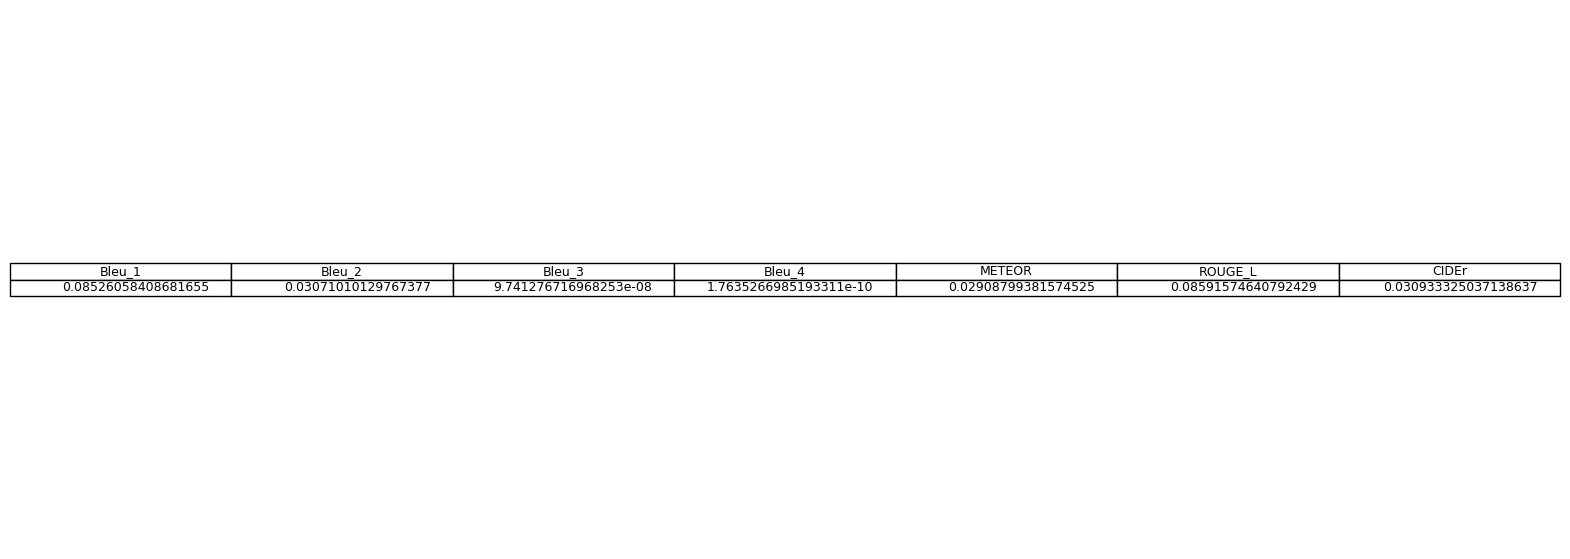

In [38]:
evaluate_model(40)

##PREPARING DATAFRAME SO THAT IT CAN GENERATE CAPTIONS FOR LUMBAR SPINE DATASET

In [43]:
import os
import shutil

def copy_all_files(source_dir, target_dir):
    # Ensure target directory exists
    os.makedirs(target_dir, exist_ok=True)

    # Walk through all subdirectories and files in the source directory
    for root, _, files in os.walk(source_dir):
        for file_name in files:
            # Construct full file path
            source_file = os.path.join(root, file_name)
            target_file = os.path.join(target_dir, file_name)

            # Copy each file to the target directory
            shutil.copy2(source_file, target_file)  # copy2 preserves metadata

    print(f"All files from {source_dir} have been copied to {target_dir}")


source_dir = r"C:\Users\BHOGI SAI SATHWIK\Desktop\DL_DATASET_PROJECT\MRI_Data"  
target_dir = r"C:\Users\BHOGI SAI SATHWIK\Desktop\DL_DATASET_PROJECT\MRI_DATA_ONLY_IMAGES"  # Replace with your target directory path
copy_all_files(source_dir, target_dir)


All files from C:\Users\BHOGI SAI SATHWIK\Desktop\DL_DATASET_PROJECT\MRI_Data have been copied to C:\Users\BHOGI SAI SATHWIK\Desktop\DL_DATASET_PROJECT\MRI_DATA_ONLY_IMAGES


##GENERATING CAPTIONS FOR LUMBAR SPINE DATASET

In [ ]:
!pip install SimpleITK
import SimpleITK as sitk

In [98]:
!pip install SimpleITK
import SimpleITK as sitk
def find_matches_from_image_to_generate_captions(model, text_embeddings, image_query, captions, n=9):
    new_image_path=r"C:\Users\BHOGI SAI SATHWIK\Desktop\DL_DATASET_PROJECT\MRI_DATA_ONLY_IMAGES"
    # image = cv2.imread(f"{new_image_path}/{image_query}")
    
    

    # Replace the original line with the following:
    # Load the .ima file using SimpleITK
    image_path = f"{new_image_path}/{image_query}"
    image_sitk = sitk.ReadImage(image_path)

    # Convert to a NumPy array
    image_np = sitk.GetArrayFromImage(image_sitk)

    # Check if it's a 3D image and select a slice if needed
    if image_np.ndim == 3:
        slice_idx = image_np.shape[0] // 2  # Selecting the middle slice for example
        image_np = image_np[slice_idx, :, :]

    # Normalize the image to 8-bit (0-255) for OpenCV display, if necessary
    image_np = cv2.normalize(image_np, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Now `image_np` holds the image data in a format compatible with OpenCV
    image = image_np  # Renaming to `image` to match original variable


    # print(image_sitk)
    # print(image)

    if image is None:
      print("GDRIVE DIDN'T READ AGAIN!")
      return 'NO_IMG_IN_GDRIVE'

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = get_transforms("valid")(image=image)['image']

    # Dymb loader
    tokenizer = AutoTokenizer.from_pretrained(CFG.clinical_encoder_model)
    dummy_df = pd.DataFrame.from_dict({"image": [image_query], "caption":[""]})
    dumb_loader = build_loaders(dummy_df, tokenizer, mode="valid")

    valid_image_embeddings = []
    with torch.no_grad():
        for batch in tqdm(dumb_loader):
            image_features = model.image_encoder(batch["image"].to(CFG.device))
            image_embeddings = model.image_projection(image_features)
            valid_image_embeddings.append(image_embeddings)

    image_embeddings_n = F.normalize(image_embeddings[0], p=2, dim=-1)
    print(image_embeddings_n.size)

    text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)
    print(text_embeddings_n.size)
    dot_similarity = image_embeddings_n @ text_embeddings_n.T
    
    values, indices = torch.topk(dot_similarity.squeeze(0), n )
    matches = [captions[idx] for idx in indices[::5]]
    
    return matches

In [99]:

# Define the path to the directory containing images
directory_path = r"C:\Users\BHOGI SAI SATHWIK\Desktop\DL_DATASET_PROJECT\MRI_DATA_ONLY_IMAGES"

# List to hold image file names
image_files = []

# Loop through files in the directory
for filename in os.listdir(directory_path):
    # if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif','.ima')):  # Adjust extensions as needed
    image_files.append(filename)

# Create a DataFrame
mriDF = pd.DataFrame(image_files, columns=["image"])

# Display the first few rows of the DataFrame
mriDF.to_csv('./mriDF.csv', index=False)






In [88]:
mriDF.head()


image
0  5002_NEW_SE_0011_001.ima
1  5002_NEW_SE_0013_001.ima
2  5002_NEW_SE_0017_001.ima
3  5002_NEW_SE_0043_001.ima
4  5002_NEW_SE_0106_001.ima

In [ ]:
import pandas as pd

def generate_captions(n=1):
    """
    Generate captions for each image in the input DataFrame.
    
    Parameters:
    - df: Input DataFrame with a column 'image' containing image file paths.
    - model: The trained model used for matching images to captions.
    - text_embeddings: Precomputed text embeddings for comparison.
    - n: Number of top matches to return for each image.
    
    Returns:
    - results_df: DataFrame containing the best match for each image.
    """
    # imagesdf = testing_df.sample(n=n)
  # print(imagesdf)
    match_results = []
    for index, row in mriDF.iterrows():
        # print(f"Image inserted: {row['image']}\nReal caption: {row['caption']}\n")

        # Top 3 matches from model.
        # print(row)
        matches = find_matches_from_image_to_generate_captions(model, 
                            text_embeddings,
                            image_query=row.image,
                            captions=df['caption'].values,
                            n=1)
        match_results.append(matches[0])
    # present_scores(row.image, row.caption, matches)
    # Initialize an empty list to store matches
    
        # Append the best match to the results list
        match_results.append(matches[0])  # Assuming matches[0] is the top match

    # Create a new DataFrame with the matches
    results_df = pd.DataFrame(match_results, columns=['Top Match Caption'])

    return results_df
# generate_captions(1)